# Priyanshu Raj 2021UCP1148

# Splitting the Dataset

In [1]:
import os
import zipfile
import random
import shutil
from PIL import Image
import matplotlib.pyplot as plt


In [2]:
# Paths
dataset_dir = './'
base_dir = './'

train_zip_path = os.path.join(dataset_dir, 'train.zip')
train_extract_dir = os.path.join(base_dir, 'train_extracted')

In [3]:

# Directories for train, validation, and test sets
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


In [4]:
# Create directories if they don't exist
os.makedirs(train_extract_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [5]:
# Extract the train.zip file
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(train_extract_dir)

# Get list of filenames
train_images_dir = os.path.join(train_extract_dir, 'train')
filenames = os.listdir(train_images_dir)

# Shuffle the filenames to ensure random distribution
random.shuffle(filenames)

#print(filenames)

In [6]:
# Calculate the number of samples for each set
total_files = len(filenames)
train_split = int(total_files * 0.7)
validation_split = int(total_files * 0.15)

# Split filenames into train, validation, and test sets
train_files = filenames[:train_split]
validation_files = filenames[train_split:train_split + validation_split]
test_files = filenames[train_split + validation_split:]

In [7]:
def move_files(file_list, source_dir, target_dir):
    for filename in file_list:
        src = os.path.join(source_dir, filename)
        dst = os.path.join(target_dir, filename)
        shutil.move(src, dst)

# Move the files to the respective directories
move_files(train_files, train_images_dir, train_dir)
move_files(validation_files, train_images_dir, validation_dir)
move_files(test_files, train_images_dir, test_dir)

print(f"Number of training samples: {len(train_files)}")
print(f"Number of validation samples: {len(validation_files)}")
print(f"Number of test samples: {len(test_files)}")

Number of training samples: 17500
Number of validation samples: 3750
Number of test samples: 3750


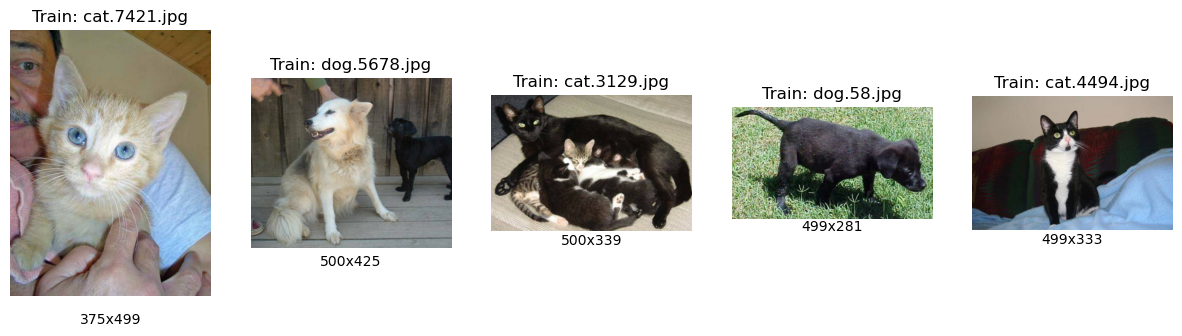

Number of images in Train Set: 17500


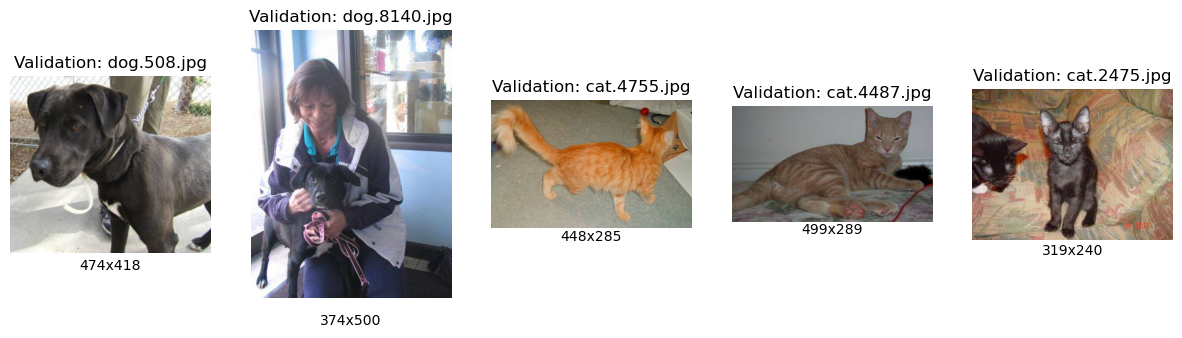

Number of images in Validation Set: 3750


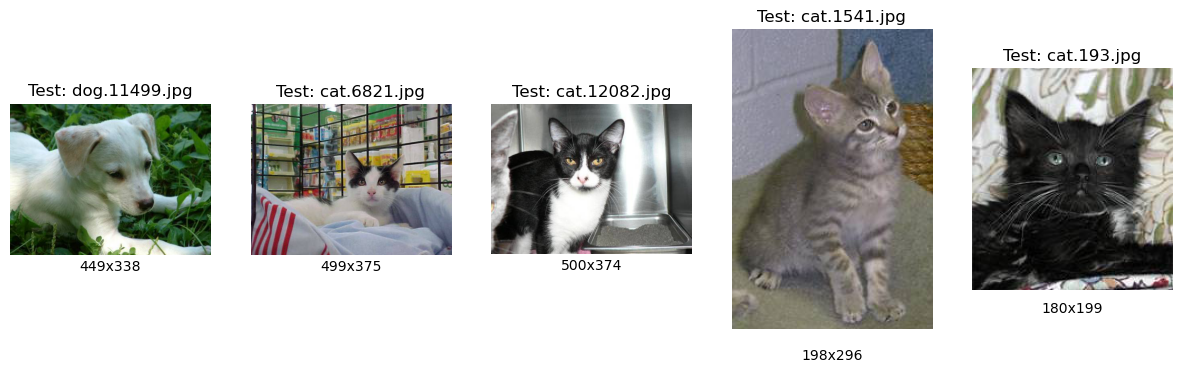

Number of images in Test Set: 3750


In [8]:
def display_samples_and_dimensions(directory, title):
    sample_files = random.sample(os.listdir(directory), 5)
    
    # Display sample images
    plt.figure(figsize=(15, 5))
    for i, filename in enumerate(sample_files):
        img = Image.open(os.path.join(directory, filename))
        width, height = img.size
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(f"{title}: {filename}")
        plt.text(0.5, -0.1, f"{width}x{height}", fontsize=10, ha='center', transform=plt.gca().transAxes)
        plt.axis('off')
    
    plt.show()

    img = Image.open(os.path.join(directory, sample_files[0]))
    width, height = img.size
    #print(f"{title} Set Dimensions: {width}x{height}")
    print(f"Number of images in {title} Set: {len(os.listdir(directory))}")

# Display samples and dimensions
display_samples_and_dimensions(train_dir, "Train")
display_samples_and_dimensions(validation_dir, "Validation")
display_samples_and_dimensions(test_dir, "Test")


# Creating labeled data

In [9]:
import numpy as np

# Helper function to load images and labels
def load_data(directory):
    files = os.listdir(directory)
    data = []
    labels = []
    for file in files:
        label = 1 if 'dog' in file else 0
        img = Image.open(os.path.join(directory, file)).resize((64, 64)) # Resize for simplicity
        img = np.array(img).flatten() # Flatten the image
        data.append(img)
        labels.append(label)
    return np.array(data), np.array(labels)

# Load data
X_train, y_train = load_data(train_dir)
X_val, y_val = load_data(validation_dir)
X_test, y_test = load_data(test_dir)
print(X_train[0])
# Normalize the data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

[206 167  90 ...   2   2   0]


# Traninig model

In [13]:
from sklearn.metrics import accuracy_score

Iteration 0: Cost 0.6931471805599453
Iteration 100: Cost 0.6826595984333066
Iteration 200: Cost 0.6776475653842872
Iteration 300: Cost 0.6742694064045737
Iteration 400: Cost 0.6717335989251894
Iteration 500: Cost 0.669711564428381
Iteration 600: Cost 0.668037369792335
Iteration 700: Cost 0.6666146533190953
Iteration 800: Cost 0.6653815385970507
Iteration 900: Cost 0.6642955167556823
Validation Accuracy: 0.61%


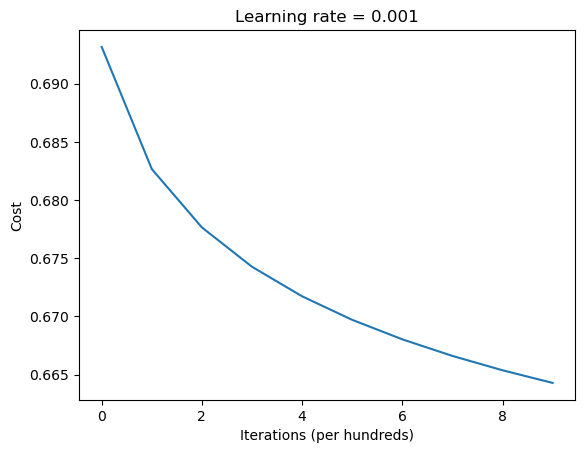

In [14]:
# Initialize parameters
def initialize_params(dim):
    w = np.zeros(dim)
    b = 0
    return w, b

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Compute cost and gradient
def compute_cost_and_gradients(X, y, w, b):
    m = X.shape[0]
    Z = np.dot(X, w) + b
    A = sigmoid(Z)
    cost = -(1 / m) * np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))
    dw = (1 / m) * np.dot(X.T, (A - y))
    db = (1 / m) * np.sum(A - y)
    return cost, dw, db

# Gradient descent
def gradient_descent(X, y, w, b, alpha, iterations):
    costs = []
    for i in range(iterations):
        cost, dw, db = compute_cost_and_gradients(X, y, w, b)
        w -= alpha * dw
        b -= alpha * db
        if i % 100 == 0:
            costs.append(cost)
            print(f"Iteration {i}: Cost {cost}")
    return w, b, costs

# Train model
def train_model(X_train, y_train, X_val, y_val, alpha, iterations):
    w, b = initialize_params(X_train.shape[1])
    w, b, costs = gradient_descent(X_train, y_train, w, b, alpha, iterations)
    
    # Evaluate on validation set
    y_val_pred = predict(X_val, w, b)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    
    return w, b, costs

# Predict function
def predict(X, w, b):
    Z = np.dot(X, w) + b
    A = sigmoid(Z)
    return np.where(A >= 0.5, 1, 0)

iterations = 1000
alpha = 0.001

w, b, costs = train_model(X_train, y_train, X_val, y_val, alpha, iterations)

# Plot the cost
plt.plot(costs)
plt.ylabel('Cost')
plt.xlabel('Iterations (per hundreds)')
plt.title(f'Learning rate = {alpha}')
plt.show()


# testing model

In [22]:
y_test_pred = predict(X_test, w, b)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}%")
print("\n")
print("The accuracy is low because we aren't considering these \nConsider Model Complexity: Logistic regression might not be sufficient for image classification. Switching to CNNs can significantly improve performance.\n Tuning and Verification: Continue experimenting with learning rates, epochs, and ensure correct data_preprocessing \nAdditional Techniques: Explore data augmentation, regularization, and class balancing methods to improve model performance.")

Test Accuracy: 0.60%


The accuracy is low because we aren't considering these 
Consider Model Complexity: Logistic regression might not be sufficient for image classification. Switching to CNNs can significantly improve performance.
 Tuning and Verification: Continue experimenting with learning rates, epochs, and ensure correct data_preprocessing 
Additional Techniques: Explore data augmentation, regularization, and class balancing methods to improve model performance.


# exp with alpha

Iteration 0: Cost 0.6931471805599453
Iteration 100: Cost 0.6826595984333066
Iteration 200: Cost 0.6776475653842872
Iteration 300: Cost 0.6742694064045737
Iteration 400: Cost 0.6717335989251894
Iteration 500: Cost 0.669711564428381
Iteration 600: Cost 0.668037369792335
Iteration 700: Cost 0.6666146533190953
Iteration 800: Cost 0.6653815385970507
Iteration 900: Cost 0.6642955167556823
Learning Rate: 0.001, Test Accuracy: 60.00%
Iteration 0: Cost 0.6931471805599453
Iteration 100: Cost 2.6057541664753385
Iteration 200: Cost 2.5811019879528425
Iteration 300: Cost 2.5547283648287133
Iteration 400: Cost 2.530697949579959
Iteration 500: Cost 2.5107532593897086
Iteration 600: Cost 2.4946835546469877
Iteration 700: Cost 2.4813150964644533
Iteration 800: Cost 2.4698727953150263
Iteration 900: Cost 2.4598962259691675
Learning Rate: 0.01, Test Accuracy: 51.57%


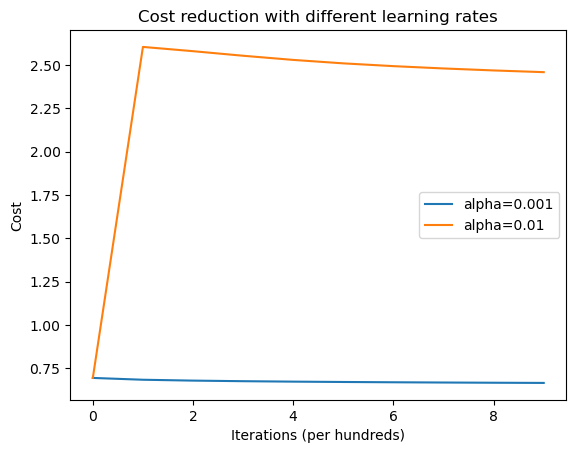

In [24]:
# Experiment with different learning rates
learning_rates = [0.001, 0.01]
for alpha in learning_rates:
    w, b = initialize_params(X_train.shape[1])
    w, b, costs = gradient_descent(X_train, y_train, w, b, alpha, iterations)
    y_pred = predict(X_test, w, b)
    accuracy = np.mean(y_pred == y_test) * 100
    print(f"Learning Rate: {alpha}, Test Accuracy: {accuracy:.2f}%")
    plt.plot(costs, label=f'alpha={alpha}')

plt.ylabel('Cost')
plt.xlabel('Iterations (per hundreds)')
plt.title('Cost reduction with different learning rates')
plt.legend()
plt.show()


# Priyanshu Raj 2021UCP1148